In [12]:
## Set the environment variables for the notebook to use a specific GPU (this can be commented out if you don't need this stuff)
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


# Import necessary packages

In [13]:
import requests
import datetime
import time
import bs4
import re
import os
from pathlib import Path


import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from fastai import *
from fastai.text import * 

## 2 Download the feedbacks for years 2016-2018 from the city of Turku API

In [14]:
#col = "score_4"

data_path = Path.home() / "data/essays.csv"
data = (pd.read_csv(data_path)
          .loc[:, ["essay_text", "theme_title"]]
      #    .assign(score_4=lambda df: pd.to_numeric(df[col], errors='coerce'))
           .dropna()
           .rename(columns={"theme_title": "label"})
       )

#data.loc[data[col] >= 0, "label"] = 'A'
#data.loc[data[col] > 99, "label"] = 'B'
#data.loc[data[col] > 100, "label"] = 'C'
#data.loc[data[col] > 150, "label"] = 'D'
#data = data.drop(columns=[col])

In [15]:
#data.groupby("label").count()

# 4 Finetune the language model to all of the scraped feedback data

In [16]:
lm_train_df = data[['label','essay_text']].copy()
lm_train_df.columns=['label','content']


# split data into training and validation set
lm_df_trn, lm_df_val = train_test_split(lm_train_df,test_size = 0.3, random_state = 12)

In [17]:
#use the fastai tokenizer with lang 'fi' (spacy)
tokenizer = Tokenizer(lang='pt', n_cpus=1)

In [18]:
data_lm = TextLMDataBunch.from_df(tokenizer=tokenizer, train_df = lm_df_trn, valid_df = lm_df_val, path = "")

In [19]:
### Here I've used hardcoded paths for the language model and vocabulary files, so change these to match your folders

weights_pretrained = '/home/danlessa/Portuguese-ULMFiT/portuguese_weights'
itos_pretrained = '/home/danlessa/Portuguese-ULMFiT/portuguese_itos'
pretrained_data = (weights_pretrained, itos_pretrained)

In [20]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150

In [21]:
learn = language_model_learner(data_lm,arch=AWD_LSTM, config=config, pretrained_fnames=pretrained_data)

In [22]:
text = "sérgio moro"
for i in range(100):
    text = learn.predict(text)
print(text)

sérgio moro ( ou em nome popular ) , era filho de um velho ( ou uns dos quatro filhos de   um dos melhores ) da família do líder pessoal da família  .  o filho segundo  ele , vê com frequência no facebook a organização , e o casal cresceu como o segundo filho de então , mas se mantém forte até hoje . a mãe causou o fato de a mãe ter desprovido de um período de tempo , o que não o levaram a se tornar um cantor .     ( )


In [23]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.save_encoder('palautetesti_10epoch_bs200')

# 5 Train the classifier with the finetuned pretrained language model

In [ ]:
#configs to make the awd-lstm architecture work (at least n_hid is different in newer version of fastai)
config_clas = {'emb_sz': 400,
 'n_hid': 1150,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': False,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2}

In [ ]:
#Let's choose a few specific classes from year 2017 for the classification task

clas_train_df = data[['label','essay_text']].copy()

clas_train_df.columns=['label','content']
# split data into training and validation set
clas_df_trn, clas_df_val = train_test_split(clas_train_df, stratify = clas_train_df['label'], test_size = 0.1, random_state = 12)

In [ ]:
#Creating a databunch. Note that the vocabulary must match the vocabulary of the language model
data_clas = TextClasDataBunch.from_df(path = "", train_df = clas_df_trn, valid_df = clas_df_val, vocab=data_lm.vocab)

In [ ]:
#Creating the learner and loarding the pretrained, finetuned language model
learn = text_classifier_learner(data_clas, config=config_clas, arch=AWD_LSTM, drop_mult=0.7)
learn.load_encoder('palautetesti_10epoch_bs200')

## 5.1 Train the classifier using gradual unfreezing to boost performance (otherwise prone to catasthropic forgetting)

First we freeze everything up to the last layer, find a good learning rate to use for cyclic learning rate. Then we save, load, freeze up to the second to last and so on. Finally we finetune the whole model

In [ ]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


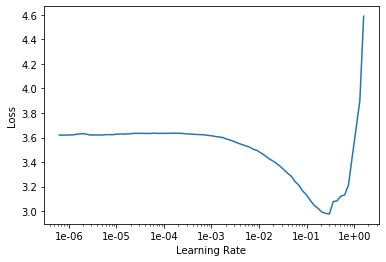

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# fit frozen model for one epoch
learn.fit_one_cycle(5,1e-2)

In [ ]:
learn.save('clas_0')

In [ ]:
learn.load('clas_0')
#Just put this here to avoid annoying outputs of learner stuff
pass

In [ ]:
# unfreeze relu layer and fit another epoch
learn.freeze_to(-2)

learn.fit_one_cycle(5,1e-2)
learn.save('clas_1')

In [ ]:
# unfreeze all layers and execute final fit
learn.load('clas_1')

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

#learn.fit_one_cycle(1,1e-2)


In [ ]:
#seems to overfit when looking at the losses, but the valid loss keeps decreasing so seems ok
learn.fit_one_cycle(3, slice(1e-03,5e-03))

In [ ]:
learn.fit_one_cycle(3, slice(1e-03,2e-03))

In [ ]:
learn.save('clas_2')

# 6 Interpreting results

In [ ]:
interp = learn.interpret()
txt_ci = TextClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(normalize=True,figsize=(6,6))

In [ ]:
learn.show_results()

## 6.1 Trying out some random sentences I made up

In [ ]:
teksti = 'Astuin Kupittaalla koiranläjään!! Voisiko aluetta siivota?'

print(learn.predict(teksti)[0])
print(learn.predict(teksti)[2])

In [ ]:
teksti = 'Visiirikadulla on myöhään illalla niin pimeää, että en löydä kotiin'

print(learn.predict(teksti)[0])
print(learn.predict(teksti)[2])

In [ ]:
teksti = """
Atualmente a ciência já desmitificou vários fatos importante importantes de grande relevância com relevância, como também contribui para contribuiu com a sociedade em diverso acontecimento histórico diversos acontecimentos históricos, porém gerou-se geraram-se outros mitos sobre a terra Terra plana ou redonda.

segundo Segundo os relatos dos livros de historias História, no período do século xiv e xv dos séculos XV e XVI, nas grandes navegações expansão marítima nas Grandes Navegações, durante a expansão marítima, tinha havia diversos mitos sobre a terra Terra que era comentado uns do grande mito o qual desse era sobre de que o planeta era plano e também poderia cair um grande abismo com diversos monstros, entretanto era no período que existia tantos recursos tecnológico com hoje de equipamento de precisão, diversas pesquisas fundamentada, publicação em revista cientifica científica conceituada a qual demonstra uma veracidade para comprovar para a população porem dúvida deixou uma lacuna em aberto para outra parte da sociedade mais em intelectual que desacorda em alguns itens ou duvida sobre a existência. São acontecimento acontecimentos de relevância que trouxe beneficio trouxeram benefícios um exemplo Albert Einstein com uma formula fórmula de energia massa velocidade luz onde contribuiu para desvenda à desvendar a energia atômica é como isso acrescentou para desenvolvimento militar como a bomba atômica mas também com usina nuclear para gerar eletricidade.

por tanto Portanto, fica claro que a ciência buscar desenvolver é contribui e demonstra para a sociedade de que realmente pode acreditar nela até porque especulação não tem fundamento cientifico científico é abstrato.
"""

print(learn.predict(teksti)[0])
print(learn.predict(teksti)[2])

The model seems to perform quite ok, at least when compared to the amount of work required to create it from the pretrained LM! This notebook can be forked to other problems too, of course.

# 7 Exporting the model example

Fastai needs all kinds of stuff to be able to load a saved model. Even though we saved the weights of the model in the training phase with the saving/loading etc. , they are useless without the vocabularies and specifications of the architecture where they fit. 

The vocabulary is needed to know how to embed the different words as vectors, and the architecture is of course needed to know which weight goes where. To make using the model in the future more convenient, it is thus best to export everything in one "package" with the learn.export() method

In [ ]:
learn.export('turku_feedback_classifier')

The exported model can then be easily loaded and used to make predictions in a production system (if you are crazy enough to use fastai for production), Kaggle submissions etc. like so:

In [ ]:
learn2 = load_learner(path='./',file='turku_feedback_classifier')

In [ ]:
learn2.predict('Santapohjantien kyltti on likainen ja pensaan peittämä')